In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# you can find all datasets at: http://fairness-measures.org/Pages/Datasets

raw_compas = pd.read_csv("https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores.csv")
raw_sqf = pd.read_csv("https://www1.nyc.gov/assets/nypd/downloads/excel/analysis_and_planning/stop-question-frisk/sqf-2017.csv")
raw_schufa = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data",sep=' ',header=None)

In [0]:
raw_compas_simon = pd.read_csv("https://raw.githubusercontent.com/MilkaLichtblau/BA_Simon/master/Simons_Arbeit/COMPAS/COMPAS.csv")
compas_cat = raw_compas_simon.select_dtypes('object').columns
raw_compas_simon[compas_cat] = raw_compas_simon[compas_cat].apply(lambda x: x.astype('category'))

raw_compas_simon[compas_cat] = raw_compas_simon[compas_cat].apply(lambda x: x.cat.codes)
X_train = raw_compas_simon

X_train_race = pd.get_dummies(X_train['race'],prefix="race")
X_train_sex = pd.get_dummies(X_train['sex'],prefix="sex")
X_train_age_cat = pd.get_dummies(X_train['age_cat'],prefix="age_cat")

X_train_onehot = pd.concat([X_train_race,X_train_sex,X_train_age_cat],axis=1).values
X_train_onehot = tf.dtypes.cast(X_train_onehot,tf.float32)

# Trying TF instead :)

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
tf.enable_eager_execution()
tf.keras.backend.clear_session()
#session = tf.InteractiveSession()

cat_vector = [6,2,3]

alpha = 0.2
noise_size = 100
batch_size = 100
gradient_penalty_weight = 10
epochs=40

# for div
p = 6
k = 2

def leaky_relu(x):
  return tf.maximum(x,alpha*x)

class Generator(tf.keras.Model):
  def __init__(self):
    super(Generator,self).__init__()
    self.fc1 = tf.keras.layers.Dense(256,activation=leaky_relu)
    self.batchnorm1 = tf.keras.layers.BatchNormalization(momentum=0.8)
    self.fc2 = tf.keras.layers.Dense(128,activation=leaky_relu)
    self.batchnorm2 = tf.keras.layers.BatchNormalization(momentum=0.8)
    self.fc3 = tf.keras.layers.Dense(64,activation=leaky_relu)
    self.batchnorm3 = tf.keras.layers.BatchNormalization(momentum=0.8)
  
  def call(self,x,cat_vec,training=True):
    x = self.fc1(x)
    x = self.batchnorm1(x,training = training)
    x = self.fc2(x)
    x = self.batchnorm2(x,training = training)
    x = self.fc3(x)
    x = self.batchnorm3(x,training = training)
    out = []
    for i in cat_vec:
      out.append(tf.keras.layers.Dense(units=i,activation=tf.nn.softmax)(x))
    x = tf.layers.flatten(tf.concat(out,1))
    return x

class Discriminator(tf.keras.Model):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.fc1 = tf.keras.layers.Dense(128,activation=leaky_relu)
    self.fc2 = tf.keras.layers.Dense(64,activation=leaky_relu)
    self.fc3 = tf.keras.layers.Dense(32,activation=leaky_relu)
    self.fc4 = tf.keras.layers.Dense(1)
    self.dropout = tf.keras.layers.Dropout(0.2)
  def call(self,x):
    x = self.fc1(x)
    x = self.dropout(x)
    x = self.fc2(x)
    x = self.dropout(x)
    x = self.fc3(x)
    x = self.dropout(x)
    x = self.fc4(x)
    return x


generator = Generator()
discriminator = Discriminator()

#generator.call = tf.contrib.eager.defun(generator.call)
#discriminator.call = tf.contrib.eager.defun(discriminator.call)

def gen_loss(x_generated):
  d_generated = discriminator(x_generated)
  return tf.reduce_mean(d_generated)

def disc_d_hat(batch,generated_batch):
  epsilon = tf.random_uniform([batch_size, 1, 1, 1], minval= 0.0, maxval=1.0,dtype=tf.float32)
  x_hat = epsilon * batch + (1-epsilon)*generated_batch
  return discriminator(x_hat),x_hat

def disc_loss(batch,generated_batch,gradients):
  ddx = tf.sqrt(tf.reduce_sum(gradients**2,axis=[1,2]))
  d_regularizer = tf.reduce_mean((ddx-1.0)**2)

  d_true = discriminator(batch)
  d_generated = discriminator(generated_batch)

  return (tf.reduce_mean(d_true)-tf.reduce_mean(d_generated)) + gradient_penalty_weight * d_regularizer

def disc_loss_div(batch,generated_batch,gradients):
  ddx = tf.reduce_sum(tf.square(gradients),reduction_indices=[1])
  gp = k* tf.reduce_mean(tf.pow(ddx,p))
  
  d_true = discriminator(batch)
  d_generated = discriminator(generated_batch)

  return (tf.reduce_mean(d_true)-tf.reduce_mean(d_generated)) + gp

disc_optimizer = tf.train.AdamOptimizer(learning_rate=0.0001, beta1=0.5, beta2=0.9)
gen_optimizer = tf.train.AdamOptimizer(learning_rate=0.0001, beta1=0.5, beta2=0.9)

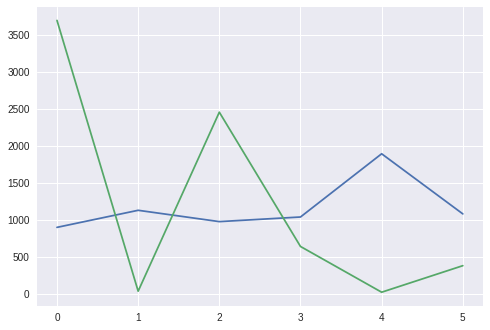

In [0]:
from IPython.display import clear_output
def generate_results(model,rows):
  r_noise = tf.random_normal([rows,noise_size],dtype=tf.float32)
  predictions = model(r_noise,cat_vector, training=False)
  return predictions

dataset = tf.data.Dataset.from_tensor_slices(X_train_onehot).batch(batch_size)

for epoch in range(epochs):

  for batch in dataset:
    noise = tf.random_normal([batch.shape[0],noise_size],dtype=tf.float32)

    for i in range(5):
      with tf.GradientTape() as disc_tape:
        generated_batch = generator(noise,cat_vector, training = True)
        with tf.GradientTape() as second_disc_tape:
          second_disc_tape.watch(batch)
          second_disc_tape.watch(generated_batch)
          d_hat,x_hat = disc_d_hat(batch,generated_batch)
          gradients = second_disc_tape.gradient(d_hat,x_hat)[0]

        discriminator_loss = disc_loss_div(batch,generated_batch,gradients)
        
      grad_of_disc = disc_tape.gradient(discriminator_loss,discriminator.variables)
      disc_optimizer.apply_gradients(zip(grad_of_disc,discriminator.variables)) 
    with tf.GradientTape() as gen_tape:
      generated_batch = generator(noise,cat_vector, training = True)
      generator_loss = gen_loss(generated_batch)

    grad_of_gen = gen_tape.gradient(generator_loss,generator.variables)
    gen_optimizer.apply_gradients(zip(grad_of_gen,generator.variables))
  if(((epoch+1)/epochs*100) % 10 ==0):
    clear_output()
    res_sum = tf.reduce_sum(generate_results(generator,7000),0)
    plt.plot(res_sum.numpy()[0:6])
    plt.plot(np.sum(X_train_onehot[:,0:6],axis=0))
    plt.show()

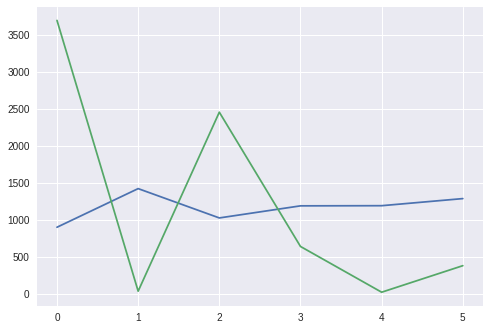

In [53]:
res_sum = tf.reduce_sum(generate_results(generator,7000),0)
plt.plot(res_sum.numpy()[0:6])
plt.plot(np.sum(X_train_onehot[:,0:6],axis=0))
plt.show()